## Exercise #6

### David Perry - sez326

### Preprocessing

In [157]:
# import packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,}'.format
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import f_regression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings('ignore')

In [158]:
# check pandas version
pd.__version__

'1.3.4'

## (6) In this exercise, you will further analyze the Wage data set considered throughout chapter 7.

In [159]:
# import data
Wage=pd.read_csv("https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Wage.csv")

#file_name = 'https://www.statlearning.com/s/wage.csv'
#Wage = pd.read_csv(file_name, index_col='SlNo')

In [160]:
Wage.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.31806333496276,75.0431540173515
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.25527250510331,70.4760196469445
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.8750612633917,130.982177377461
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.04139268515823,154.68529299563
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.31806333496276,75.0431540173515


In [161]:
Wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3000 non-null   int64  
 1   year        3000 non-null   int64  
 2   age         3000 non-null   int64  
 3   sex         3000 non-null   object 
 4   maritl      3000 non-null   object 
 5   race        3000 non-null   object 
 6   education   3000 non-null   object 
 7   region      3000 non-null   object 
 8   jobclass    3000 non-null   object 
 9   health      3000 non-null   object 
 10  health_ins  3000 non-null   object 
 11  logwage     3000 non-null   float64
 12  wage        3000 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 304.8+ KB


In [162]:
Wage.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,"3,000.0","218,883.37","145,654.07","7,373.0","85,622.25","228,799.5","374,759.5","453,870.0"
year,"3,000.0","2,005.79",2.03,"2,003.0","2,004.0","2,006.0","2,008.0","2,009.0"
age,"3,000.0",42.41,11.54,18.0,33.75,42.0,51.0,80.0
logwage,"3,000.0",4.65,0.35,3.0,4.45,4.65,4.86,5.76
wage,"3,000.0",111.7,41.73,20.09,85.38,104.92,128.68,318.34


### 6.a. Polynomial regression to predict wage using age (through cross-validation to select the optimal degree, $d$)

In [163]:
from sklearn.model_selection import KFold as KF, cross_val_score as CVS
from sklearn.linear_model import LinearRegression

In [164]:
X = Wage[['age']]
y = Wage[['wage']]

In [165]:
# selecting M, the number of components that give the lowest cross-validation error
n = len(X)
kf10 = KF(n_splits=10, shuffle=True, random_state=42)

lm = LinearRegression()
MSEdf= pd.DataFrame()
Xi = pd.DataFrame()

# calculating MSE with only the intercept through cross-validation
mse = -1*CVS(lm, np.ones((n,1)), y, cv=kf10, scoring='neg_mean_squared_error').mean()    
MSEdf = MSEdf.append([round(mse, 9)], ignore_index=True)

# calculating MSE for 15 degrees through cross-validation
for i in np.arange(1, 15):
    Xi = pd.concat([Xi, X**i], axis = 1)
    mse = -1*CVS(lm, Xi.iloc[:,:i], y, cv=kf10, scoring='neg_mean_squared_error').mean()
    MSEdf = MSEdf.append([round(mse, 9)])
    
MSEdf.reset_index(drop=True, inplace=True)
MSEdf.columns = ['MSE']
MSEdf

,MSE
0,"1,741.674153197"
1,"1,677.503541934"
2,"1,600.903452329"
3,"1,597.002914788"
4,"1,595.880330176"
5,"1,595.980487762"
6,"1,595.37154196"
7,"1,595.695466656"
8,"1,596.012513335"
9,"1,596.243895607"


In [166]:
# minimum MSEdf
MSEdf.min()

MSE   1,595.37154196
dtype: float64

Text(0, 0.5, 'Mean Squared Error (CV)')

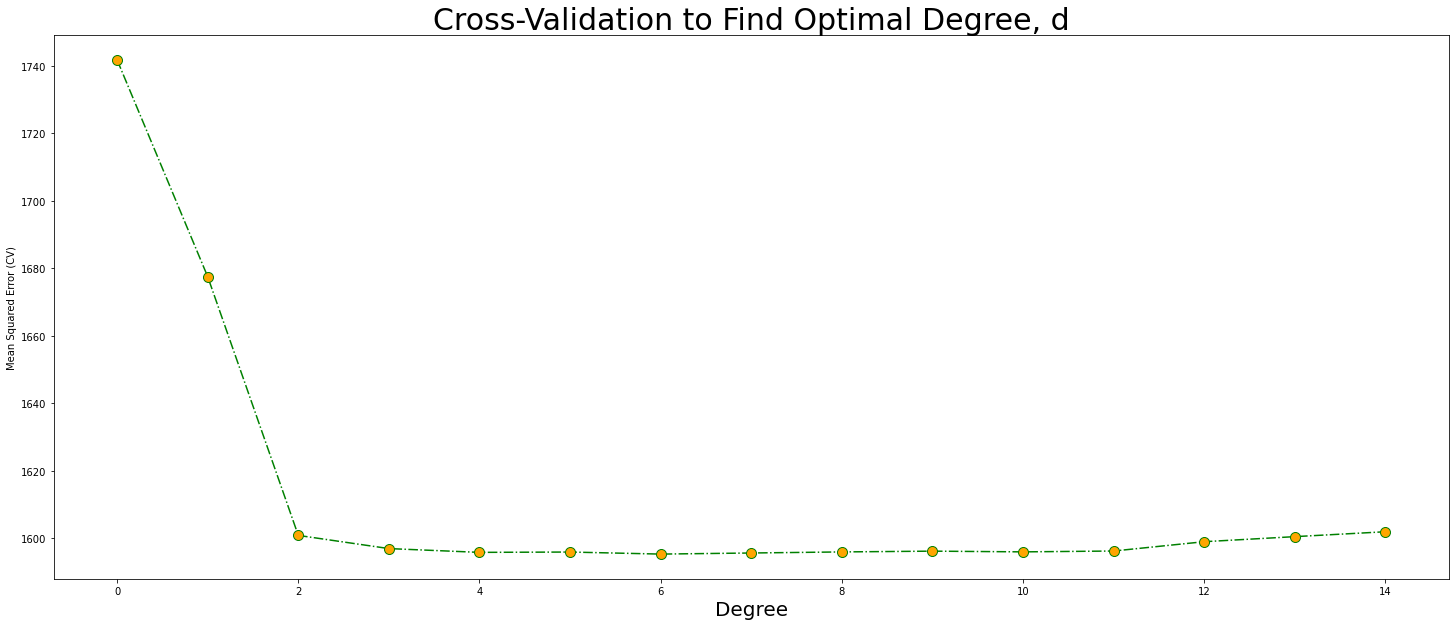

In [167]:
# plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(MSEdf, color='g',  linestyle='-.', marker='o', markerfacecolor='orange', markersize=10)
plt.title('Cross-Validation to Find Optimal Degree, d', fontsize=30)
plt.xlabel('Degree', fontsize=20)
plt.ylabel('Mean Squared Error (CV)')

**Cross-validation suggests $d$=6 to be give the smallest error and therefore is the optimal degree.**

**Comparing it with $d$=4, which as suggested in other examples as the best fit.**

In [168]:
df = pd.concat([y, X, X**2, X**3, X**4, X**5, X**6], axis=1)
df.columns = ['wage', 'age', 'age^2', 'age^3', 'age^4', 'age^5', 'age^6']
lmfit4 = ols("df['wage']~df['age']+df['age^2']+df['age^3']+df['age^4']", data=df).fit()
lmfit5 = ols("df['wage']~df['age']+df['age^2']+df['age^3']+df['age^4']+df['age^5']", data=df).fit()
lmfit6 = ols("df['wage']~df['age']+df['age^2']+df['age^3']+df['age^4']+df['age^5']+df['age^6']", data=df).fit()

In [169]:
anova_table = sm.stats.anova_lm(lmfit4, lmfit5, lmfit6, typ=1)
anova_table.index = anova_table.index+1
anova_table.round(2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,"2,995.0","4,771,604.25",0.0,NaN,NaN,NaN
2,"2,994.0","4,770,321.69",1.0,"1,282.56",0.81,0.37
3,"2,993.0","4,766,389.43",1.0,"3,932.26",2.47,0.12


**ANOVA however suggests that any degree, $d$>4 is not statistically significant (since the $p$-value>5 for $d$>4).**

Text(0, 0.5, 'Wage')

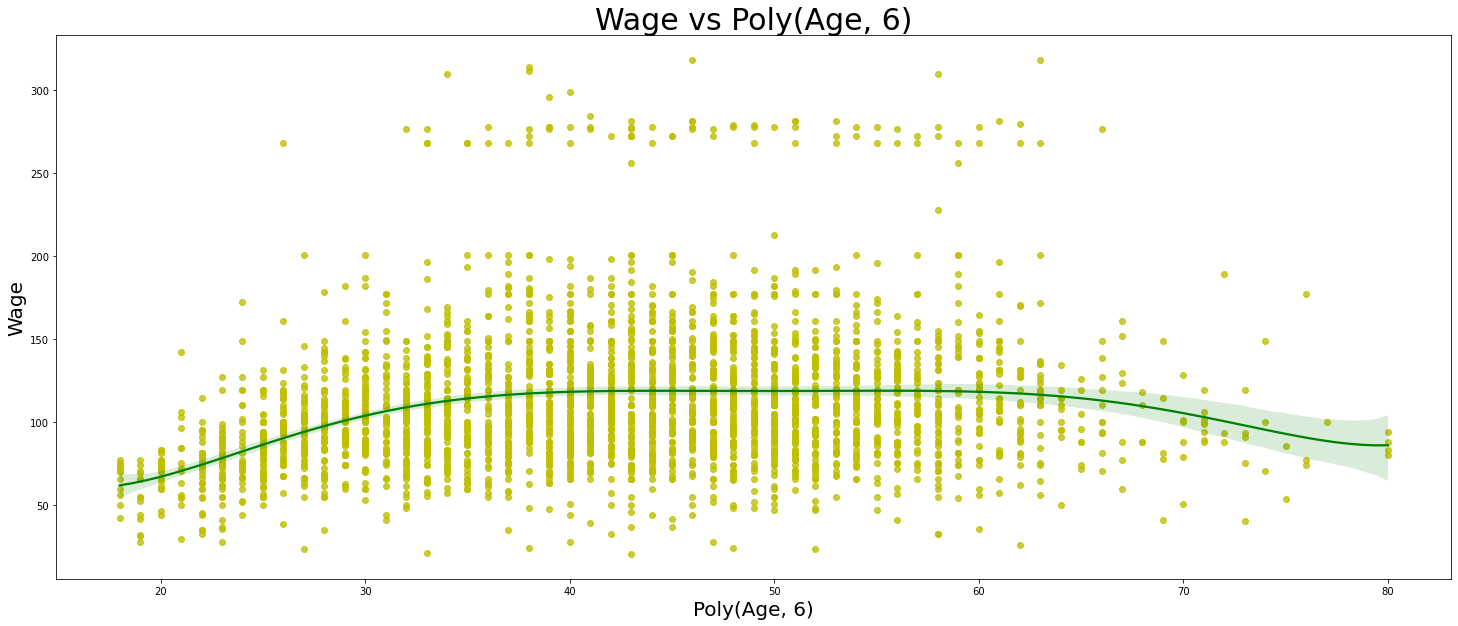

In [170]:
X1 = Wage['age']
X2 = X1**2
X3 = X1**3
X4 = X1**4
X5 = X1**5
X6 = X1**6
plotdf = pd.concat([y, X1, X2, X3, X4, X5, X6], axis=1)
plotdf.columns = ['wage', 'age', 'age^2', 'age^3', 'age^4', 'age^5', 'age^6']
# plt.xkcd()
plt.figure(figsize = (25, 10))
sns.regplot('age', 'wage', data=plotdf, fit_reg=True, ci = 95, color='y', order=6, line_kws={'color':'green'})
plt.title('Wage vs Poly(Age, 6)', fontsize=30)
plt.xlabel('Poly(Age, 6)', fontsize=20)
plt.ylabel('Wage', fontsize=20)

### 6.b. Step function to predict wage using age (through cross-validation to select the optimal number of cuts)

In [171]:
df = pd.concat([y, X], axis=1)
Wage_cut, bins = pd.cut(Wage.age, 4, retbins = True, right = True)
df.head()

,wage,age
0,75.0431540173515,18
1,70.4760196469445,24
2,130.982177377461,45
3,154.68529299563,43
4,75.0431540173515,50


In [172]:
# selecting M, the number of components that give the lowest cross-validation error
n = len(X)
kf10 = KF(n_splits=10, shuffle=True, random_state=42)

MSEdf= pd.DataFrame()
lm = LinearRegression()

# calculating MSE with only the intercept through cross-validation
mse = -1*CVS(lm, np.ones((n,1)), y, cv=kf10, scoring='neg_mean_squared_error').mean()    
MSEdf = MSEdf.append([round(mse, 9)], ignore_index=True)

# calculating MSE for 15 degrees through cross-validation
for i in np.arange(1, 15):
    X = pd.DataFrame(pd.cut(Wage.age, i))
    X = pd.get_dummies(X)
    y = Wage.wage
    mse = -1*CVS(lm, X, y, cv=kf10, scoring='neg_mean_squared_error').mean()
    MSEdf = MSEdf.append([round(mse, 9)])
    
MSEdf.reset_index(drop=True, inplace=True)
MSEdf.columns = ['MSE']
MSEdf

,MSE
0,"1,741.674153197"
1,"1,741.674153197"
2,"1,734.802510172"
3,"1,683.901607936"
4,"1,636.250891066"
5,"1,631.735970919"
6,"1,623.649395751"
7,"1,613.326824012"
8,"1,602.098828742"
9,"1,613.615844308"


In [173]:
# minimum MSEdf
MSEdf.min()

MSE   1,600.077986868
dtype: float64

Text(0, 0.5, 'Mean Squared Error')

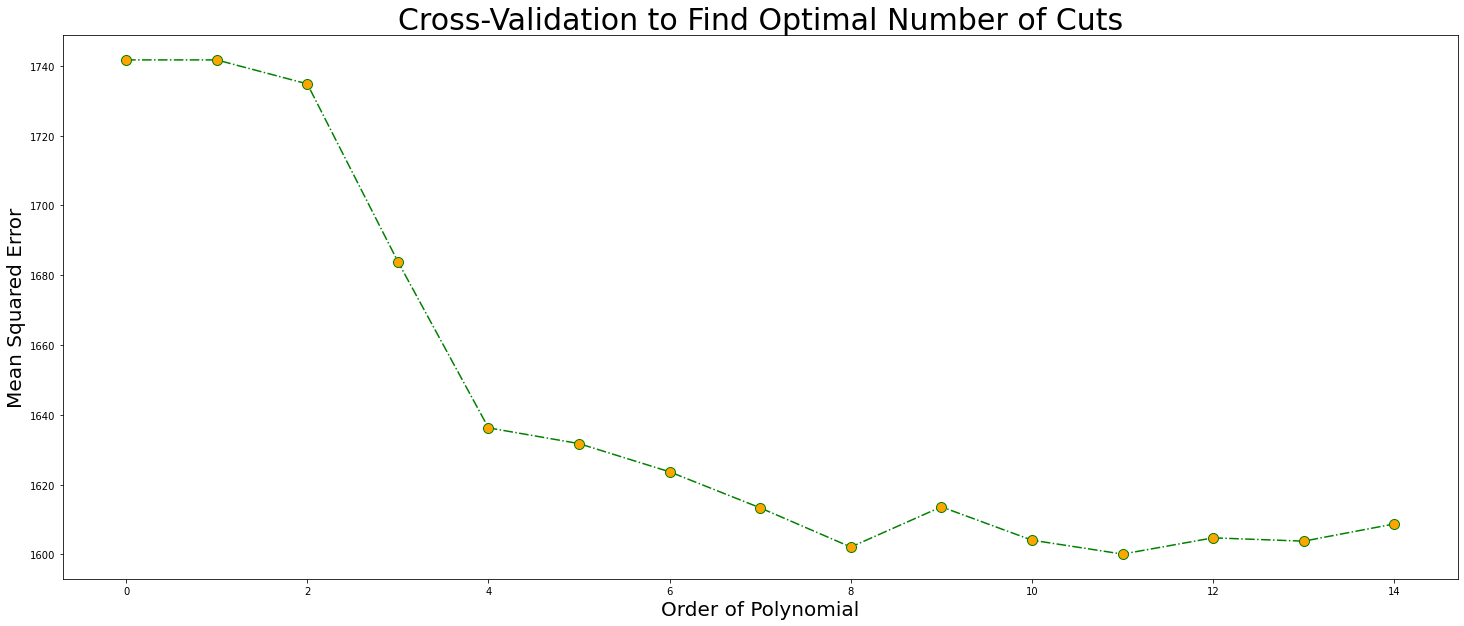

In [174]:
# plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(MSEdf, color='g',  linestyle='-.', marker='o', markerfacecolor='orange', markersize=10)
plt.title('Cross-Validation to Find Optimal Number of Cuts', fontsize=30)
plt.xlabel('Order of Polynomial', fontsize=20)
plt.ylabel('Mean Squared Error', fontsize=20)

**From the graph, it's clear that the MSE is least at $M$=11.**

**Performing regression**

In [175]:
dfX = pd.DataFrame(pd.cut(Wage.age, 11))
dfX = pd.get_dummies(dfX)
dfX['age'] = Wage.age
dfy = Wage.wage
df_step = pd.concat([dfy, dfX], axis=1)
df_step.head()

,wage,"age_(17.938, 23.636]","age_(23.636, 29.273]","age_(29.273, 34.909]","age_(34.909, 40.545]","age_(40.545, 46.182]","age_(46.182, 51.818]","age_(51.818, 57.455]","age_(57.455, 63.091]","age_(63.091, 68.727]","age_(68.727, 74.364]","age_(74.364, 80.0]",age
0,75.0431540173515,1,0,0,0,0,0,0,0,0,0,0,18
1,70.4760196469445,0,1,0,0,0,0,0,0,0,0,0,24
2,130.982177377461,0,0,0,0,1,0,0,0,0,0,0,45
3,154.68529299563,0,0,0,0,1,0,0,0,0,0,0,43
4,75.0431540173515,0,0,0,0,0,1,0,0,0,0,0,50


In [176]:
X = df_step[df_step.columns.difference(['wage', 'age'])]
y = df_step['wage']

lmfitOLS = ols('y~X', data=df_step).fit()
lmfit = LinearRegression().fit(X, y)

In [177]:
lmfitOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     28.50
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           9.76e-53
Time:                        20:50:59   Log-Likelihood:                -15313.
No. Observations:                3000   AIC:                         3.065e+04
Df Residuals:                    2989   BIC:                         3.071e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     96.6639      1.423     67.942      0.000      93.874      99.454
X[0]         -26.0835      3.364     -7.753      0.000     -32.680     -19.487
X[1]          -2.3649      2.526     -0.936      0.349      -7.318       2.589
X[2]           9.6848      2.354      4.114      0.000       5.069      14.300
X[3]          20.9179      2.160      9.683      0.000      16.682      25.154
X[4]          23.3151      2.112     11.042      0.000      19.175      27.455
X[5]          20.4873      2.230      9.188      0.000      16.115      24.859
X[6]          20.6974      2.374      8.718      0.000      16.042      25.352
X[7]          24.0585      2.826      8.514      0.000      18.518      29.599
X[8]          11.2129      5.739      1.954      0.051      -0.040      22.466
X[9]           0.3308      6.807      0.049      0.961     -13.015      13.677
X[10]         -5.5923     11.617     -0.481      0.630     -28.370      17.185
==============================================================================
Omnibus:                     1082.397   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4821.671
Skew:                           1.701   Prob(JB):                         0.00
Kurtosis:                       8.197   Cond. No.                     3.21e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.3e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Text(0, 0.5, 'Wage')

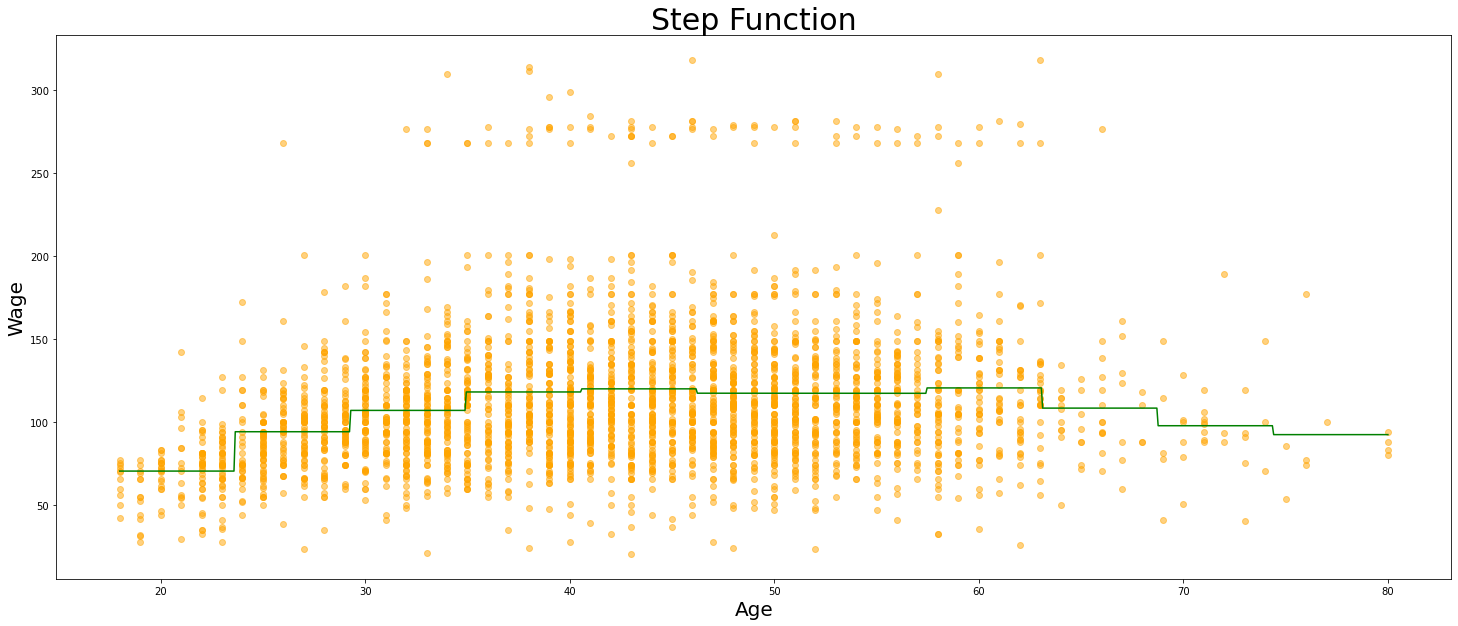

In [178]:
# plt.xkcd()
plt.figure(figsize=(25, 10))
plt.scatter(df_step.age, df_step.wage, color='orange', alpha=.5)
agerange = np.linspace(df_step.age.min(), df_step.age.max(), 1000)
agerange_d = pd.get_dummies(pd.cut(agerange, 11))
predictions = lmfit.predict(agerange_d)
plt.plot(agerange, predictions, color='g')
plt.title('Step Function', fontsize=30)
plt.xlabel('Age', fontsize=20)
plt.ylabel('Wage', fontsize=20)

## 10. This question relates to the [College data set](https://www.statlearning.com/s/College.csv).

In [179]:
df = pd.read_csv('https://www.statlearning.com/s/College.csv', index_col=0)

# Dummy variables
# The feature 'Private' is categorical. In order to use it in our models, we need to use dummy variables.
college = pd.get_dummies(df)
college.head()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_No,Private_Yes
Abilene Christian University,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,0,1
Adelphi University,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,0,1
Adrian College,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,0,1
Agnes Scott College,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,0,1
Alaska Pacific University,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,0,1


### (a) Split the data into a training set and a test set. Using out-of-state tuition as the response and the other variables as the predictors, perform forward stepwise selection on the training set in order to identify a satisfactory model that uses just a subset of the predictors.

In [180]:
# Dataset
X = college.drop(['Outstate'], axis=1)
y = college['Outstate']

# Split into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

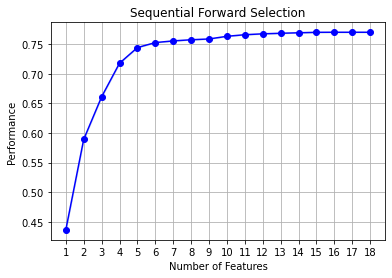

In [181]:
# Forward stepwise selection
lr = LinearRegression()

sfs = SFS(lr,
          k_features = 18,  # We have 18 features
          forward = True,
          floating = False,
          scoring = 'r2',
          cv = 0)

sfs = sfs.fit(X_train, y_train)  # as_matrix() to be readable by sfs

fig = plot_sfs(sfs.get_metric_dict())

#plt.title('Sequential forward selection (w. StdDev)')
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

We will choose _6 features._ The figure shows that a larger number of features will not increase the performance significantly.

In [182]:
# Visualizing the results in dataframes
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(7,)",[0.4362198079356785],0.4362198079356785,"(Room.Board,)",NaN,0.0,NaN
2,"(7, 13)",[0.5892065138987024],0.5892065138987024,"(Room.Board, perc.alumni)",NaN,0.0,NaN
3,"(7, 13, 14)",[0.66124161844549],0.66124161844549,"(Room.Board, perc.alumni, Expend)",NaN,0.0,NaN
4,"(7, 13, 14, 16)",[0.7180472594803899],0.7180472594803899,"(Room.Board, perc.alumni, Expend, Private_No)",NaN,0.0,NaN
5,"(7, 10, 13, 14, 16)",[0.7445389170091503],0.7445389170091503,"(Room.Board, PhD, perc.alumni, Expend, Private...",NaN,0.0,NaN
6,"(7, 10, 13, 14, 15, 16)",[0.7529797180569529],0.7529797180569529,"(Room.Board, PhD, perc.alumni, Expend, Grad.Ra...",NaN,0.0,NaN
7,"(7, 9, 10, 13, 14, 15, 16)",[0.7558186916454233],0.7558186916454233,"(Room.Board, Personal, PhD, perc.alumni, Expen...",NaN,0.0,NaN
8,"(4, 7, 9, 10, 13, 14, 15, 16)",[0.7577507694491248],0.7577507694491248,"(Top25perc, Room.Board, Personal, PhD, perc.al...",NaN,0.0,NaN
9,"(1, 4, 7, 9, 10, 13, 14, 15, 16)",[0.7590884961181228],0.7590884961181228,"(Accept, Top25perc, Room.Board, Personal, PhD,...",NaN,0.0,NaN
10,"(0, 1, 4, 7, 9, 10, 13, 14, 15, 16)",[0.7635928325779913],0.7635928325779913,"(Apps, Accept, Top25perc, Room.Board, Personal...",NaN,0.0,NaN


In [183]:
# Variables that we will choose
print('Variables: %s, %s, %s, %s, %s, %s' % (X.columns[16], X.columns[7], X.columns[10], X.columns[13], X.columns[14], X.columns[15]))

Variables: Private_No, Room.Board, PhD, perc.alumni, Expend, Grad.Rate


In [184]:
selected_features = ["Private_No", "Room.Board", "PhD", "perc.alumni", "Expend", "Grad.Rate"]
selected_features

['Private_No', 'Room.Board', 'PhD', 'perc.alumni', 'Expend', 'Grad.Rate']

### (b) Fit a GAM on the training data, using out-of-state tuition as the response and the features selected in the previous step as the predictors. Plot the results, and explain your findings.

In pyGAM, you can either use `.fit()` or `.gridsearch()` to fit GAMs on the training set. The difference is that `.gridsearch()` performs a grid search over a space of all tunable parameters; see [API](https://pygam.readthedocs.io/en/latest/api/gam.html). Thus, `.gridsearch()` is slow but may have better results.

In [185]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

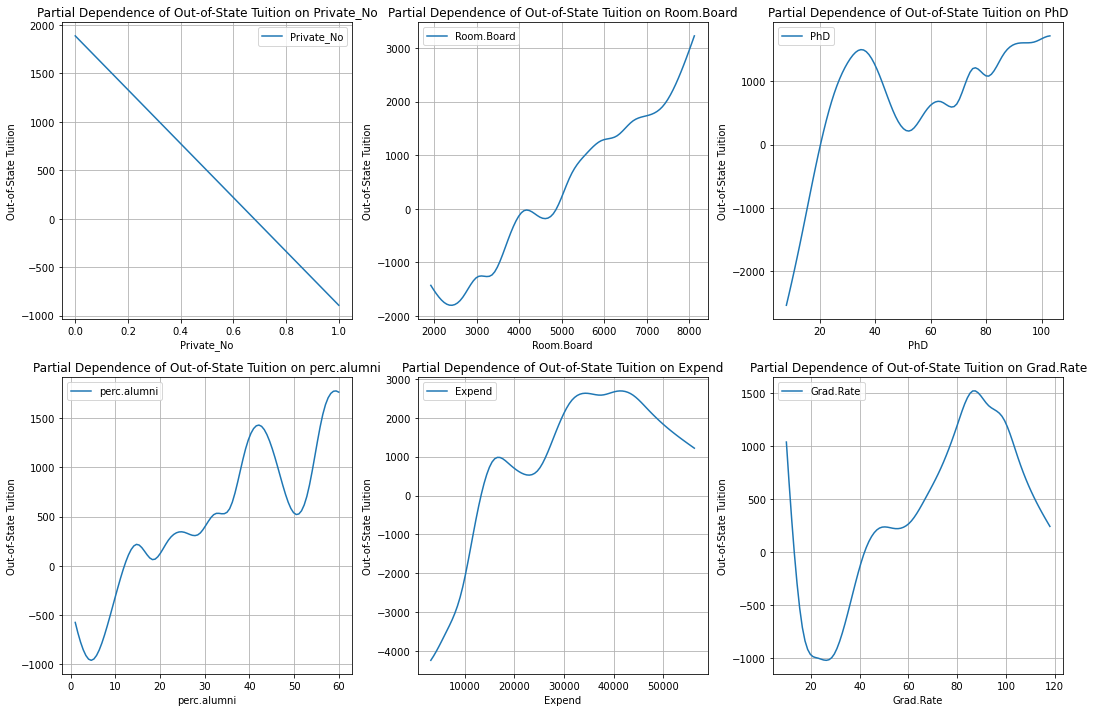

In [186]:
from pygam import LinearGAM, s, f, l
#from pygam import (s as s_gam, l as l_gam, f as f_gam, LinerarGAM, LogisticGam, te)
# Fit GAM model
gam = LinearGAM().fit(X_train_selected, y_train)

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 3, i + 1)
    XX = gam.generate_X_grid(term=i)
    partial_dep = gam.partial_dependence(term=i, X=XX)
    plt.plot(XX[:, i], partial_dep, label=feature)
    plt.title("Partial Dependence of Out-of-State Tuition on {}".format(feature))
    plt.xlabel(feature)
    plt.ylabel("Out-of-State Tuition")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [187]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     53.5653
Link Function:                     IdentityLink Log Likelihood:                                 -8679.2047
Number of Samples:                          543 AIC:                                            17467.5399
                                                AICc:                                           17479.9803
                                                GCV:                                          4232277.0771
                                                Scale:                                        3488086.0916
                                                Pseudo R-Squared:                                   0.8034
Feature Function                  Lam

In this code:

 - We select the features from the dataset based on the results of forward stepwise selection.
 - We fit a Generalized Additive Model (GAM) using the LinearGAM class from PyGAM.
 - We plot the partial dependence plots for each selected feature using the partial_dependence method of the GAM model.

### (c) Evaluate the model obtained on the test set, and explain the results obtained.

In [189]:
# Evaluate the model on the test set
test_score = gam.score(X_test_selected, y_test)
print("Test Set R^2 Score:", test_score)

AttributeError: 'LinearGAM' object has no attribute 'score'

### (d) For which variables, if any, is there evidence of a non-linear relationship with the response?

We can inspect the partial dependence plots from Part (b). If the curves are non-linear, it suggests a non-linear relationship between the predictor and the response.